<a href="https://colab.research.google.com/github/amantayal44/CS779_Project/blob/main/Result.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from numpy import dot
from numpy.linalg import norm
import random
import numpy as np

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
''' Loading trained embeddings: embed_orig and embed_gn and Glove embeddings: embed_glove and embed_gn_glove '''
import pickle
with open("gdrive/MyDrive/data/embedding/embedding.pickle", 'rb') as handle:
    embed_orig =  pickle.load(handle)
with open("gdrive/MyDrive/data/embedding/GN_embedding.pickle", 'rb') as handle:
    embed_gn =  pickle.load(handle)
with open("gdrive/MyDrive/data/embedding/glove_embedding.pickle", 'rb') as handle:
    embed_glove =  pickle.load(handle)
with open("gdrive/MyDrive/data/embedding/gn_glove_embedding.pickle", 'rb') as handle:
    embed_gn_glove =  pickle.load(handle)
#Opening the list of gender specific words
gs_words = open('g_words', encoding='utf-8').read().strip().split('\n')

In [6]:
#List of gender direction words, m_words contain male part of pair and f_words contain female part e.g. m_words[0] = "he" and f_words[0] = "she"
m_words = ["he","his","man","john","himself","son","father","guy","boy","male"]
f_words = ["she","her","woman","mary","herself","daughter","mother","gal","girl","female"]

In [7]:
#Function to calculate gender subspace of embed, num_dir is the number of PC to include in gender subspace, here taken as 3
def calc_gdirec(embed,num_dir):
  m_emb = [embed[w] for w in m_words]
  f_emb = [embed[w] for w in f_words]
  g_sub = [[m[i]-f[i] for i in range(len(m))]for (m,f) in zip(m_emb,f_emb)]
  scaler = StandardScaler()
  scaler.fit(g_sub)
  scaled_gsub = scaler.transform(g_sub)
  pca = PCA()
  pca.fit(scaled_gsub)
  g_direc = pca.components_[:num_dir]
  return g_direc,pca.components_,pca.explained_variance_ratio_

#Cosine of two vectors
def cosine(a,b):
  return dot(a,b)/(norm(a)*norm(b))

#Function to calculate projection of a vector x on subspace
def projection(x,subspace):
  return norm(np.sum([cosine(v,x)*v for v in subspace],axis=0))

#Function to Calculate bias of embedding given gender subspace to be g_direc
def calc_bias(embed,g_direc):
  gn_words = [word for word in embed if word not in gs_words]
  print("num_gn_words ",len(gn_words))
  return sum([abs(projection(embed[word],g_direc)) for word in gn_words])/len(gn_words)

In [8]:
#Calculating Gender Subspace of all 4 embeddings
g_direc1,_,var_ratio1 = calc_gdirec(embed_orig,3) 
g_direc2,_,var_ratio2 = calc_gdirec(embed_gn,3)
g_direc3,_,var_ratio3 = calc_gdirec(embed_glove,3)
g_direc4,_,var_ratio4 = calc_gdirec(embed_gn_glove,3)

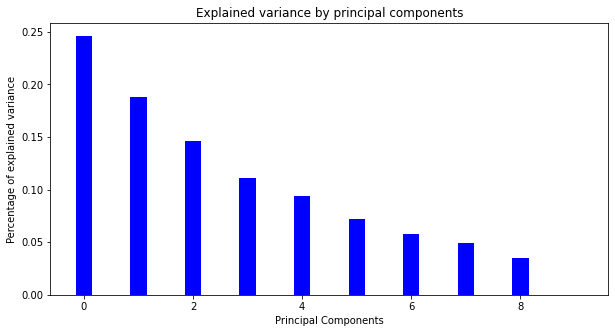

In [9]:
#Plotting Variance explained by each of the PC obtained from embed_orig i.e. original trained embedding
x_axis = [i for i in range(len(var_ratio1))]
y_axis = var_ratio1
fig = plt.figure(figsize = (10, 5))
plt.bar(x_axis,y_axis, color ='blue',
        width = 0.3)
plt.xlabel("Principal Components")
plt.ylabel("Percentage of explained variance")
plt.title("Explained variance by principal components")
plt.savefig('pca_final',dpi=720)

num_gn_words  44805
num_gn_words  44805
num_gn_words  43946
num_gn_words  27237


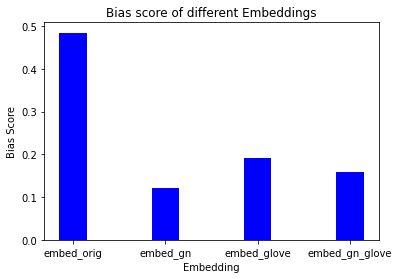

In [10]:
#Calculating bias of all 4 embeddings and plotting a bar plot of the values
bias1 = calc_bias(embed_orig,g_direc1)
bias2 = calc_bias(embed_gn,g_direc2)
bias3 = calc_bias(embed_glove,g_direc3)
bias4 = calc_bias(embed_gn_glove,g_direc4)
x = ["embed_orig","embed_gn","embed_glove","embed_gn_glove"]
y = [bias1,bias2,bias3,bias4]
plt.bar(x,y, color ='blue',
        width = 0.3)
plt.title('Bias score of different Embeddings')
plt.xlabel('Embedding')
plt.ylabel('Bias Score')
plt.savefig('bias_final',dpi=720)


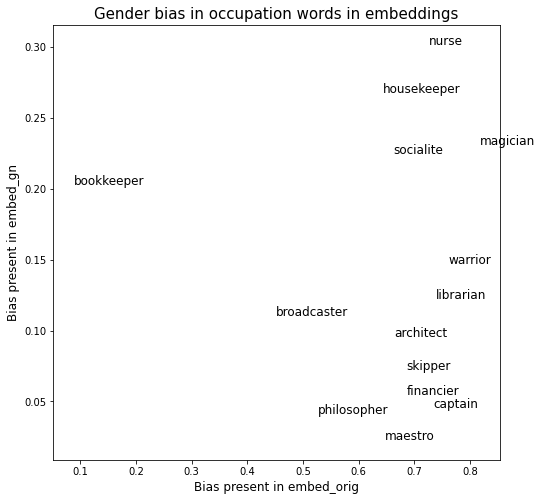

In [11]:
''' Plotting some stereotypical occupations with respect to bias scores in Original embedding and GN-embedding '''
#occupation is the list of all occupations stereotypicallly labelled as male or female
occupation = ["nurse","librarian","socialite","bookkeeper","housekeeper","maestro","skipper","philosopher","captain","architect","financier","warrior","broadcaster","magician"]
#x coordinates are the bias scores of words in embed_orig and y coordinates are bias scores in embed_gn
x = [projection(embed_orig[word],g_direc1) for word in occupation]
y = [projection(embed_gn[word],g_direc2) for word in occupation]
plt.figure(figsize=(8,8))
plt.xlabel("Bias present in embed_orig",size=12)
plt.ylabel("Bias present in embed_gn",size=12)
plt.title("Gender bias in occupation words in embeddings",size=15)
plt.scatter(x, y,c='white')
for i in range(len(occupation)):
  plt.annotate(occupation[i],(x[i],y[i]),size=12)
plt.savefig('occupation_final',dpi=720)

In [12]:
#Function to calculate cosine similarity between two vectors
from sklearn.metrics.pairwise import cosine_similarity
def get_cosine_similarity(feature_vec_1, feature_vec_2):    
    return cosine_similarity(feature_vec_1.reshape(1, -1), feature_vec_2.reshape(1, -1))[0][0]

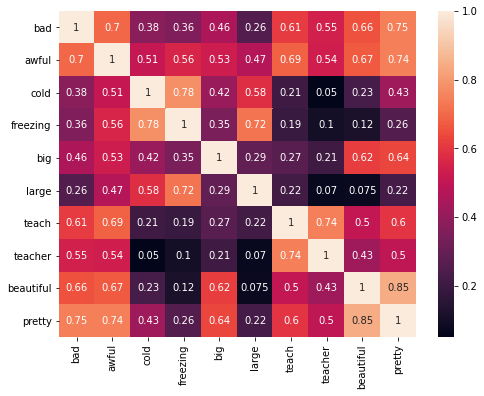

In [13]:
words = ['bad','awful','cold','freezing','big','large','teach','teacher','beautiful','pretty']
data = []
for word1 in words:
  temp = []
  for word2 in words:
    sim = get_cosine_similarity(embed_orig[word1],embed_orig[word2])
    temp.append(sim)
  data.append(temp)
import seaborn as sns
plt.figure(figsize=(8,6))
sns.heatmap(data,annot=True,xticklabels=words,yticklabels=words)
plt.savefig('similarity_final')